# Part 1: Load and Merge CSV Files

In [133]:
import os
import pandas as pd
from glob import glob

# Load all CSVs in the current directory
data_dir = os.getcwd()
csv_files = [f for f in glob(os.path.join(data_dir, "*.csv")) if f.endswith(".csv")]

df_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df['source_file'] = os.path.basename(file)
        df_list.append(df)
        # print(f"Loaded {file} → shape: {df.shape}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all into one DataFrame
merged_df = pd.concat(df_list, ignore_index=True)
# print("Merged shape:", merged_df.shape)

# # Preview a few rows
# display(merged_df.head())


# Part 2: Preprocessing – Strip, Drop, Encode

In [127]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Clean column names
merged_df.columns = merged_df.columns.str.strip()

# Drop non-numeric columns (but keep 'Label')
non_numeric = merged_df.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric = [col for col in non_numeric if col != 'Label']
merged_df.drop(columns=non_numeric, inplace=True)

# Fill NaNs with column means
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
merged_df[numeric_cols] = merged_df[numeric_cols].fillna(merged_df[numeric_cols].mean())

# Replace infinite values with column max (safely)
for col in numeric_cols:
    inf_mask = np.isinf(merged_df[col])
    if inf_mask.any():
        merged_df.loc[inf_mask, col] = merged_df[col][~inf_mask].max()

# Handle label encoding
if 'Label' in merged_df.columns:
    if merged_df['Label'].dtype == object or merged_df['Label'].dtype.name == 'category':
        le = LabelEncoder()
        merged_df['Label'] = le.fit_transform(merged_df['Label'])
        class_names = list(le.classes_)
    else:
        # Assume already numeric — define known class names manually
        class_names = [
            "BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris",
            "FTP-Patator", "Heartbleed", "Infiltration", "PortScan", "SSH-Patator",
            "Web Attack – Brute Force", "Web Attack – Sql Injection", "Web Attack – XSS"
        ]
    # print("Label classes:", class_names)
else:
    raise ValueError("Missing 'Label' column after merge.")

# print("Preprocessed shape:", merged_df.shape)
# display(merged_df.head())


# Part 3: Train-Test Split and Scaling

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# Drop label and source_file if it exists
drop_cols = ['Label']
if 'source_file' in merged_df.columns:
    drop_cols.append('source_file')

X = merged_df.drop(columns=drop_cols)
y = merged_df['Label']

# Clamp values to safe range
X = X.clip(lower=-1e6, upper=1e6)

# Ensure numeric-only and clean
X = X.select_dtypes(include=[np.number])
X = X.dropna(axis=1, how='all')
X = X.fillna(X.mean())
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.max(), inplace=True)

# Final check
if not np.all(np.isfinite(X.values)):
    raise ValueError("X still contains invalid values.")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to training data (for tuned models)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Print summary
# print("Train shape:", X_train.shape)
# print("Test shape:", X_test.shape)
# print("Resampled shape:", X_train_resampled.shape)


# Part 4: Train and Evaluate Models

## Evaluate Stock Models


In [57]:
# Step 4 - Evaluate STOCK Models 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results_stock = {}
conf_matrices_stock = {}

def evaluate_stock_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results_stock[name] = {
        'precision': report['weighted avg']['precision'],
        'recall':    report['weighted avg']['recall'],
        'f1-score':  report['weighted avg']['f1-score'],
        'accuracy':  acc
    }

    conf_matrices_stock[name] = confusion_matrix(y_test, y_pred)

    print(f"\n{name.upper()} EVALUATION (PER CLASS):")
    print(f"{'Class':<30}{'Precision':>12}{'Recall':>12}{'F1-Score':>12}")
    for i, label in enumerate(class_names):
        row = report[str(i)]
        print(f"{label:<30}{row['precision']:>12.4f}{row['recall']:>12.4f}{row['f1-score']:>12.4f}")

    print(f"\n{name} Summary Metrics:")
    print(f"{'Accuracy:':<12} {acc:.4f}")
    print(f"{'Precision:':<12} {report['weighted avg']['precision']:.4f}")
    print(f"{'Recall:':<12} {report['weighted avg']['recall']:.4f}")
    print(f"{'F1-Score:':<12} {report['weighted avg']['f1-score']:.4f}")

# Run stock models
evaluate_stock_model("Random Forest (Stock)", RandomForestClassifier(n_estimators=100, random_state=42))
evaluate_stock_model("SVM (Stock)", SVC(kernel='rbf', random_state=42))
evaluate_stock_model("MLP (Stock)", MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))



RANDOM FOREST (STOCK) EVALUATION (PER CLASS):
Class                            Precision      Recall    F1-Score
BENIGN                              0.9875      0.9875      0.9875
Bot                                 1.0000      0.9500      0.9744
DDoS                                1.0000      1.0000      1.0000
DoS GoldenEye                       0.9524      1.0000      0.9756
DoS Hulk                            0.9500      0.9500      0.9500
DoS Slowhttptest                    1.0000      1.0000      1.0000
DoS slowloris                       0.9500      0.9500      0.9500
FTP-Patator                         1.0000      1.0000      1.0000
Heartbleed                          1.0000      1.0000      1.0000
Infiltration                        1.0000      1.0000      1.0000
PortScan                            1.0000      0.9500      0.9744
SSH-Patator                         1.0000      1.0000      1.0000
Web Attack � Brute Force            0.6111      0.5500      0.5789
Web Attack � Sq

## Evaluate Tuned Models

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate using resampled training data
results_tuned = {}
conf_matrices_tuned = {}

def evaluate_tuned_model(name, model):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results_tuned[name] = {
        'precision': round(report['weighted avg']['precision'], 4),
        'recall':    round(report['weighted avg']['recall'], 4),
        'f1-score':  round(report['weighted avg']['f1-score'], 4),
        'accuracy':  round(acc, 4)
    }

    conf_matrices_tuned[name] = confusion_matrix(y_test, y_pred)

    print(f"\n{name.upper()} EVALUATION (PER CLASS):")
    print(f"{'Class':<30}{'Precision':>10}{'Recall':>10}{'F1-Score':>10}")
    for i, label in enumerate(class_names):
        row = report[str(i)]
        print(f"{label:<30}{row['precision']:>10.4f}{row['recall']:>10.4f}{row['f1-score']:>10.4f}")

    print(f"\n{name} Summary Metrics:")
    print(f"{'Accuracy:':<12} {acc:.4f}")
    print(f"{'Precision:':<12} {report['weighted avg']['precision']:.4f}")
    print(f"{'Recall:':<12} {report['weighted avg']['recall']:.4f}")
    print(f"{'F1-Score:':<12} {report['weighted avg']['f1-score']:.4f}")

# Run tuned models
evaluate_tuned_model("Random Forest (Tuned)", RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
))

evaluate_tuned_model("SVM (Tuned)", SVC(
    kernel='rbf',
    C=5,
    gamma='scale',
    random_state=42
))

evaluate_tuned_model("MLP (Tuned)", MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    max_iter=1000,
    random_state=42
))



RANDOM FOREST (TUNED) EVALUATION (PER CLASS):
Class                          Precision    Recall  F1-Score
BENIGN                            0.9937    0.9875    0.9906
Bot                               1.0000    0.9500    0.9744
DDoS                              1.0000    1.0000    1.0000
DoS GoldenEye                     0.9524    1.0000    0.9756
DoS Hulk                          0.9524    1.0000    0.9756
DoS Slowhttptest                  1.0000    1.0000    1.0000
DoS slowloris                     0.9500    0.9500    0.9500
FTP-Patator                       1.0000    1.0000    1.0000
Heartbleed                        1.0000    1.0000    1.0000
Infiltration                      1.0000    1.0000    1.0000
PortScan                          1.0000    0.9500    0.9744
SSH-Patator                       1.0000    1.0000    1.0000
Web Attack � Brute Force          0.6875    0.5500    0.6111
Web Attack � Sql Injection        0.8000    1.0000    0.8889
Web Attack � XSS                  0.58

# Part 5: Model Comparison: Stock vs Tunned

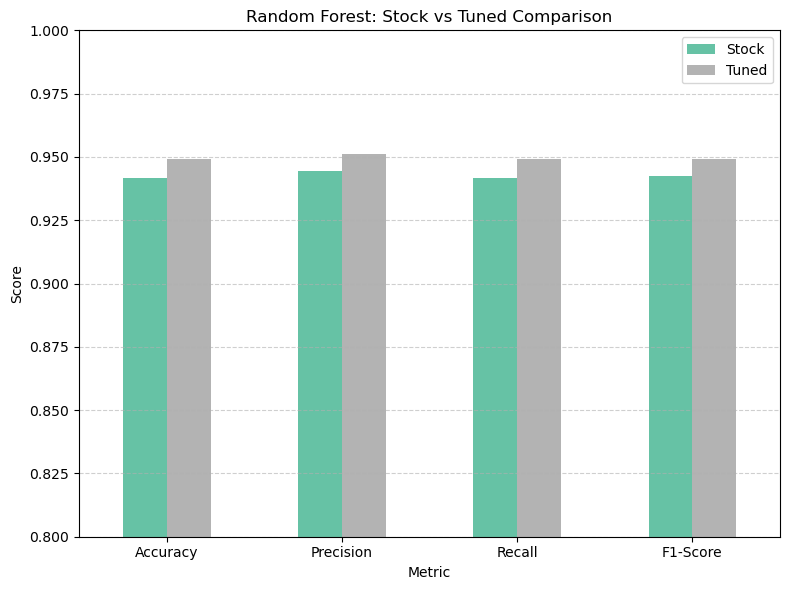

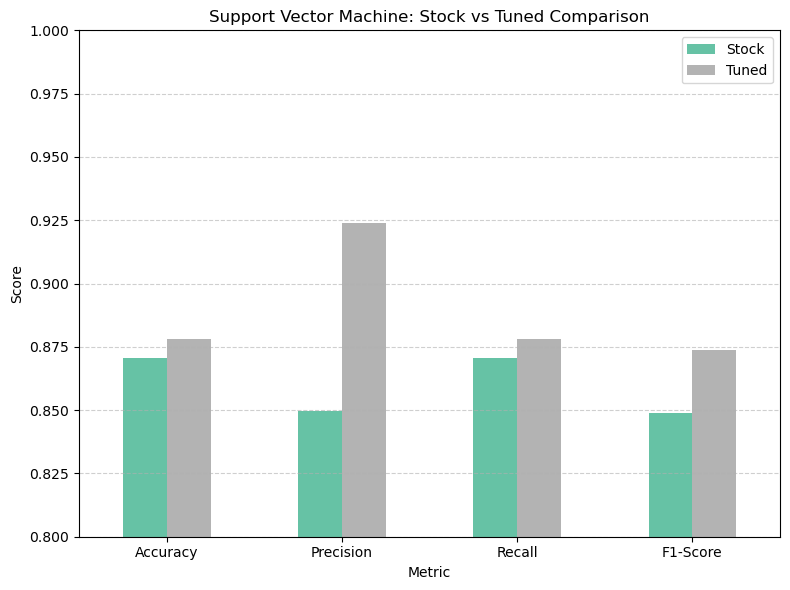

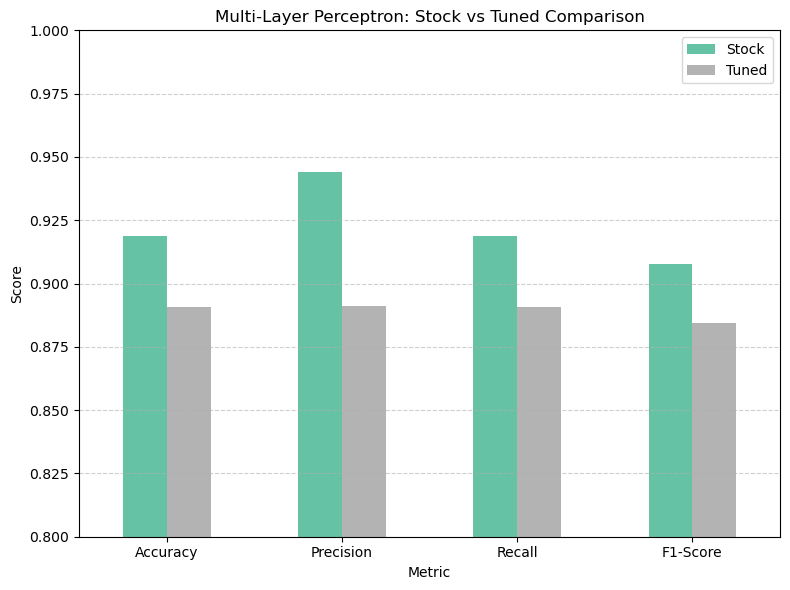

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Helper function to build comparison DataFrame and plot it
def plot_model_comparison(model_name_stock, model_name_tuned, display_title):
    stock = results_stock[model_name_stock]
    tuned = results_tuned[model_name_tuned]

    df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Stock': [stock['accuracy'], stock['precision'], stock['recall'], stock['f1-score']],
        'Tuned': [tuned['accuracy'], tuned['precision'], tuned['recall'], tuned['f1-score']],
    })

    df.set_index('Metric').plot(kind='bar', figsize=(8, 6), colormap='Set2')
    plt.title(f'{display_title}: Stock vs Tuned Comparison')
    plt.ylabel('Score')
    plt.ylim(0.8, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot charts for each model
plot_model_comparison("Random Forest (Stock)", "Random Forest (Tuned)", "Random Forest")
plot_model_comparison("SVM (Stock)", "SVM (Tuned)", "Support Vector Machine")
plot_model_comparison("MLP (Stock)", "MLP (Tuned)", "Multi-Layer Perceptron")


# Part 6: Model Comparison: Stock Models Comparison Chart

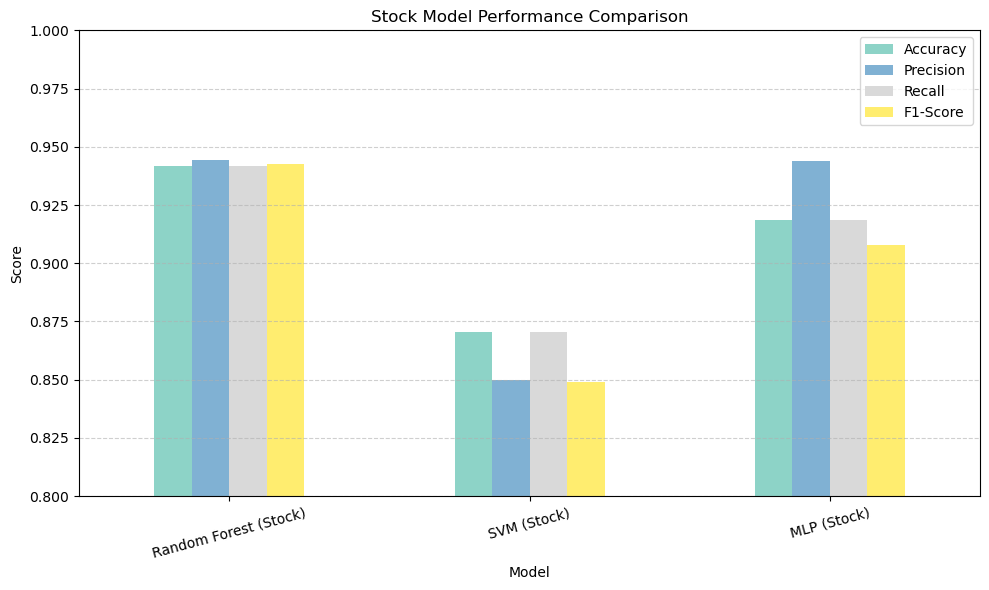

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract stock model metrics
model_names = ["Random Forest (Stock)", "SVM (Stock)", "MLP (Stock)"]

accuracy = [results_stock[m]['accuracy'] for m in model_names]
precision = [results_stock[m]['precision'] for m in model_names]
recall = [results_stock[m]['recall'] for m in model_names]
f1 = [results_stock[m]['f1-score'] for m in model_names]

# Create DataFrame for plotting
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Model')

# Plot combined chart
metrics_df.plot(kind='bar', figsize=(10, 6), colormap='Set3')
plt.title('Stock Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Part 7: Model Comparison: Tuned Models Comparison Chart

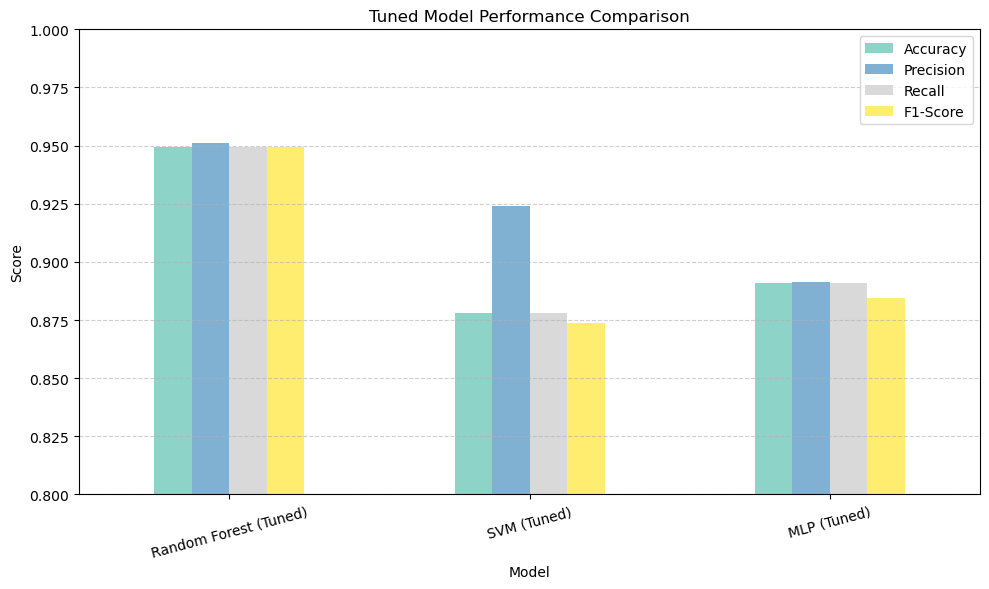

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract tuned model metrics
model_names = ["Random Forest (Tuned)", "SVM (Tuned)", "MLP (Tuned)"]

accuracy = [results_tuned[m]['accuracy'] for m in model_names]
precision = [results_tuned[m]['precision'] for m in model_names]
recall = [results_tuned[m]['recall'] for m in model_names]
f1 = [results_tuned[m]['f1-score'] for m in model_names]

# Create DataFrame
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Model')

# Plot chart with matching color scheme
metrics_df.plot(kind='bar', figsize=(10, 6), colormap='Set3')
plt.title('Tuned Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
